In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X = np.loadtxt("/content/drive/MyDrive/Colab files/DI_ekosistema/X.csv", delimiter=",")
y = np.loadtxt("/content/drive/MyDrive/Colab files/DI_ekosistema/y.csv", delimiter=",").astype(np.int32)

y = np.array([[1 if j == i else 0 for j in range(10)] for i in y])

In [3]:
def plot(images):
  fig, axes = plt.subplots(10, 10, figsize=(10, 10))
  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img.reshape(10, 10), "binary");
    ax.set_xticks([])
    ax.set_yticks([])

In [49]:
def plot_history(history):
  plt.plot(history["train_loss"], label="Treniravimo netektis");
  plt.plot(history["val_loss"], label="Patvirtinimo netektis");
  plt.plot(history["train_accuracy"], label="Treniravimo tikslumas");
  plt.plot(history["val_accuracy"], label="Patvirtinimo tikslumas");
  plt.legend()
  plt.xlabel("Epochų skaičius")
  plt.ylim([0, 1.25])
  plt.show()

In [55]:
def plot_histories_mses(history1, history2):
  plt.plot(history1["train_loss"], label="Vienasluoksnio treniravimo netektis");
  plt.plot(history1["val_loss"], label="Vienasluoksnio patvirtinimo netektis");
  plt.plot(history2["train_loss"], label="Daugiasluoksnio treniravimo netektis");
  plt.plot(history2["val_loss"], label="Daugiasluoksnio patvirtinimo netektis");
  plt.legend()
  plt.xlabel("Epochų skaičius")
  plt.ylim([0, 0.75])
  plt.show()

In [56]:
def plot_histories_accuracies(history1, history2):
  plt.plot(history1["train_accuracy"], label="Vienasluoksnio treniravimo tikslumas");
  plt.plot(history1["val_accuracy"], label="Vienasluoksnio patvirtinimo tikslumas");
  plt.plot(history2["train_accuracy"], label="Daugiasluoksnio treniravimo tikslumas");
  plt.plot(history2["val_accuracy"], label="Daugiasluoksnio patvirtinimo tikslumas");
  plt.legend()
  plt.xlabel("Epochų skaičius")
  plt.ylim([0, 1])
  plt.show()

### Data

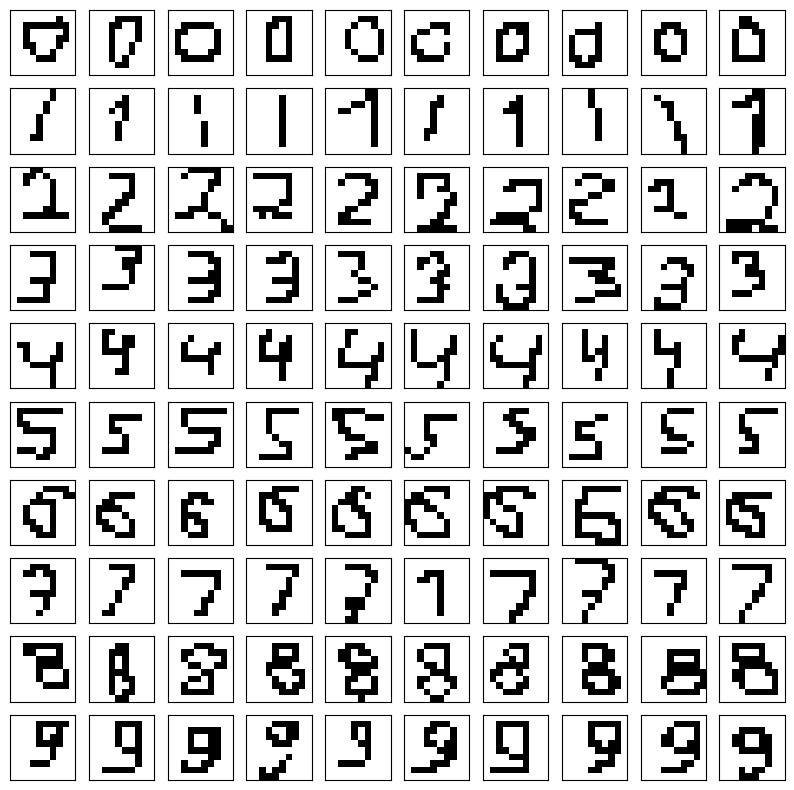

In [43]:
indeces = np.array([np.random.choice(range(i * 100, i * 100 + 100), 10, replace=False) for i in range(10)]).ravel()
plot(X[indeces])

### Data splitting

In [6]:
def train_test_split(X, y, test_size):
  n = len(X) // test_size
  train_indeces = np.array([np.random.choice(range(i * n, i * n + n), test_size, replace=False) for i in range(10)]).ravel()
  return np.delete(X, train_indeces, axis=0), X[train_indeces], np.delete(y, train_indeces, axis=0), y[train_indeces]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 10)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 10)

### Model building blocks

In [36]:
class Sigmoid():
  def __init__(this):
    this.layer_type= "activation"

  def forward(this, X):
    this.output = 1 / (1 + np.exp(-X))
    return this.output

  def backward(this, gradient):
    this.gradient = this.output * (1 - this.output) * gradient
    return this.gradient


class Layer():
  def __init__(this, input_size, layer_size, initialization_technique="rand_zeros"):
    if initialization_technique == "rand_zeros":
      this.W = np.random.rand(input_size, layer_size)
      this.b = np.zeros((1, layer_size))
    elif initialization_technique == "randn_rand":
      this.W = np.random.randn(input_size, layer_size)
      this.b = np.random.rand(1, layer_size)
    this.layer_type= "layer"

  def forward(this, X):
    this.input = X
    this.output = np.matmul(X, this.W)
    return this.output

  def backward(this, gradient):
    this.dW = np.matmul(this.input.T, gradient)
    this.db = np.sum(gradient, axis=0)
    this.gradient = np.matmul(gradient, this.W.T)
    return this.gradient

  def optimize(this, learning_rate):
    this.W = this.W - this.dW * learning_rate
    this.b = this.b - this.db * learning_rate


class MSE():
  def __init__(this):
    pass

  def forward(this, y_pred, y_true):
    this.error = y_pred - y_true
    this.output = np.sum(this.error ** 2, axis=1)
    return this.output

  def backward(this):
    return this.error


class Model_Base():
  def __init__(this, sequential):
    this.sequential = sequential
    this.history = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}

  def predict(this, X):
    for layer in this.sequential:
      X = layer.forward(X)
    return X

  def backward(this, gradient):
    for layer in reversed(this.sequential):
      gradient = layer.backward(gradient)

  def optimize(this, learning_rate):
    for layer in this.sequential:
      if layer.layer_type == "layer":
        layer.optimize(learning_rate)

  def fit(this, X, y, epochs, learning_rate, loss_fn, batch_size, val_data=None, print_info=False):
    # Training
    for i in range(epochs):
      indeces = np.random.choice(len(X), len(X), replace=False)
      for j in range(len(X) // batch_size):
        X_batch = X[indeces[j * batch_size : j * batch_size + 10]]
        y_batch = y[indeces[j * batch_size : j * batch_size + 10]]
        y_pred = this.predict(X_batch)
        loss = loss_fn.forward(y_pred, y_batch)
        gradient = loss_fn.backward()
        this.backward(gradient)
        this.optimize(learning_rate)
      # Saving and printing info
      y_pred_train = this.predict(X)
      loss_train = loss_fn.forward(y_pred_train, y)
      acc_train = accuracy(y_pred_train, y)
      this.history["train_loss"].append(np.sum(loss_train) / len(loss_train))
      this.history["train_accuracy"].append(acc_train)
      if type(val_data) != type(None):
        X_val, y_val = val_data
        y_pred_val = this.predict(X_val)
        loss_val = loss_fn.forward(y_pred_val, y_val)
        acc_val = accuracy(y_pred_val, y_val)
        this.history["val_loss"].append(np.sum(loss_val) / len(loss_val))
        this.history["val_accuracy"].append(acc_val)
        if print_info:
          print(f"Epoch: {i + 1} Train loss: {round(np.sum(loss_train) / len(loss_train), 2)} Train accuracy: {round(acc_train * 100, 2)}% Validation loss: {round(np.sum(loss_val) / len(loss_val), 2)} Validation accuracy: {round(acc_val * 100, 2)}%")
      elif print_info:
        print(f"Epoch: {i + 1} Train loss: {round(np.sum(loss_train) / len(loss_train), 2)} Train accuracy: {round(acc_train * 100, 2)}%")



class Model_ZeroHiddenLayers(Model_Base):
  def __init__(this):
    this.sequential = (
        Layer(100, 10),
        Sigmoid()
    )
    super().__init__(this.sequential)


class Model_TwoHiddenLayers(Model_Base):
  def __init__(this):
    this.sequential = (
        Layer(100, 16, initialization_technique="randn_rand"),
        Sigmoid(),
        Layer(16, 16, initialization_technique="randn_rand"),
        Sigmoid(),
        Layer(16, 10, initialization_technique="randn_rand")
    )
    super().__init__(this.sequential)

In [9]:
def accuracy(y_pred, y_true):
  return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)) / len(y_pred)

## One layer ANN

In [10]:
model = Model_ZeroHiddenLayers()
pred = model.predict(X_train)
print(accuracy(pred, y_train))

0.0675


In [11]:
model.fit(X_train, y_train, epochs=1000, learning_rate=0.03, loss_fn=MSE(), batch_size=10, val_data=(X_val, y_val), print_info=True)

Epoch: 1 Train loss: 8.97 Train accuracy: 7.12% Validation loss: 8.98 Validation accuracy: 5.0%
Epoch: 2 Train loss: 8.97 Train accuracy: 7.38% Validation loss: 8.97 Validation accuracy: 5.0%
Epoch: 3 Train loss: 8.95 Train accuracy: 7.5% Validation loss: 8.95 Validation accuracy: 6.0%
Epoch: 4 Train loss: 8.87 Train accuracy: 7.62% Validation loss: 8.87 Validation accuracy: 7.0%
Epoch: 5 Train loss: 8.09 Train accuracy: 7.38% Validation loss: 8.12 Validation accuracy: 8.0%
Epoch: 6 Train loss: 7.41 Train accuracy: 7.12% Validation loss: 7.42 Validation accuracy: 8.0%
Epoch: 7 Train loss: 7.37 Train accuracy: 7.38% Validation loss: 7.38 Validation accuracy: 9.0%
Epoch: 8 Train loss: 7.35 Train accuracy: 7.62% Validation loss: 7.36 Validation accuracy: 10.0%
Epoch: 9 Train loss: 7.33 Train accuracy: 7.62% Validation loss: 7.34 Validation accuracy: 10.0%
Epoch: 10 Train loss: 7.31 Train accuracy: 7.88% Validation loss: 7.32 Validation accuracy: 11.0%
Epoch: 11 Train loss: 7.23 Train accu

In [12]:
pred = model.predict(X_test)
print(accuracy(pred, y_test))

0.81


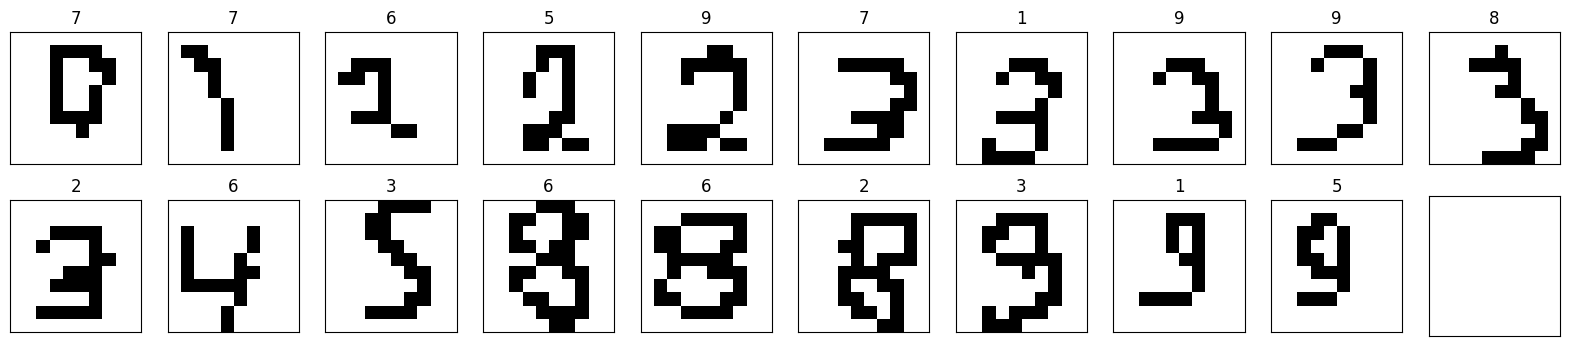

In [17]:
X_incorrects = X_test[np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)]
y_incorrects = np.argmax(pred[np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)], axis=1)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(len(X_incorrects)):
  i_a = i // 10
  j_a = i % 10
  axes[i_a, j_a].imshow(X_incorrects[i].reshape(10, 10), "binary")
  axes[i_a, j_a].set_title(y_incorrects[i])

for ax in axes.ravel():
  ax.set_yticks([])
  ax.set_xticks([])

plt.show()

In [34]:
X_corrects = X_test[np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)]
y_corrects = np.argmax(pred[np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)], axis=1)
for i in range(10):
  i_acc =  len(X_corrects[y_corrects == i]) / 10
  false_answers =  np.argmax(pred[np.all(((np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)), (i == np.argmax(y_test, axis=1))), axis=0)], axis=1)
  print(f"{i} {round(i_acc * 100, 2)}%")
  print(false_answers)

0 90.0%
[7]
1 90.0%
[7]
2 70.0%
[6 5 9]
3 40.0%
[7 1 9 9 8 2]
4 90.0%
[6]
5 90.0%
[3]
6 100.0%
[]
7 100.0%
[]
8 70.0%
[6 6 2]
9 70.0%
[3 1 5]


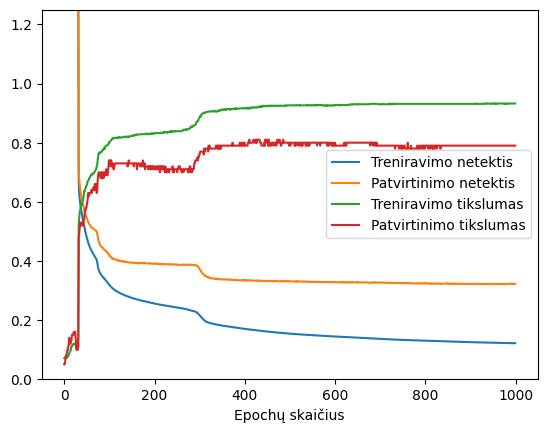

In [47]:
plot_history(model.history)

## Deep ANN

In [37]:
model_deep = Model_TwoHiddenLayers()
pred = model_deep.predict(X_train)
print(accuracy(pred, y_train))

0.1


In [38]:
model_deep.fit(X_train, y_train, epochs=1000, learning_rate=0.01, loss_fn=MSE(), batch_size=10, val_data=(X_val, y_val), print_info=True)

Epoch: 1 Train loss: 1.47 Train accuracy: 12.12% Validation loss: 1.49 Validation accuracy: 9.0%
Epoch: 2 Train loss: 1.11 Train accuracy: 15.38% Validation loss: 1.14 Validation accuracy: 11.0%
Epoch: 3 Train loss: 1.02 Train accuracy: 16.88% Validation loss: 1.04 Validation accuracy: 13.0%
Epoch: 4 Train loss: 1.0 Train accuracy: 19.5% Validation loss: 1.02 Validation accuracy: 17.0%
Epoch: 5 Train loss: 0.97 Train accuracy: 16.88% Validation loss: 0.99 Validation accuracy: 13.0%
Epoch: 6 Train loss: 0.94 Train accuracy: 22.62% Validation loss: 0.96 Validation accuracy: 15.0%
Epoch: 7 Train loss: 0.96 Train accuracy: 14.5% Validation loss: 0.98 Validation accuracy: 13.0%
Epoch: 8 Train loss: 0.88 Train accuracy: 24.25% Validation loss: 0.9 Validation accuracy: 16.0%
Epoch: 9 Train loss: 0.89 Train accuracy: 23.25% Validation loss: 0.91 Validation accuracy: 18.0%
Epoch: 10 Train loss: 0.89 Train accuracy: 25.75% Validation loss: 0.91 Validation accuracy: 21.0%
Epoch: 11 Train loss: 0.

In [39]:
pred = model_deep.predict(X_test)
print(accuracy(pred, y_test))

0.83


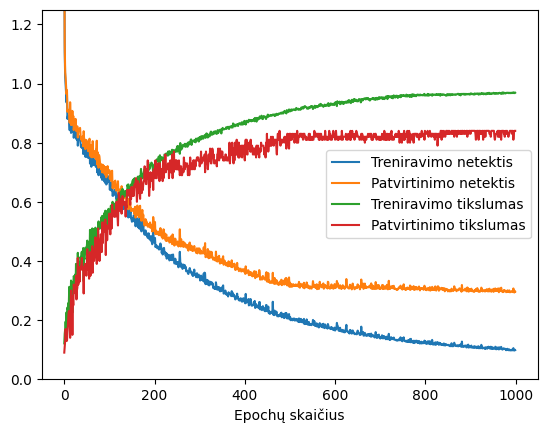

In [46]:
plot_history(model_deep.history)

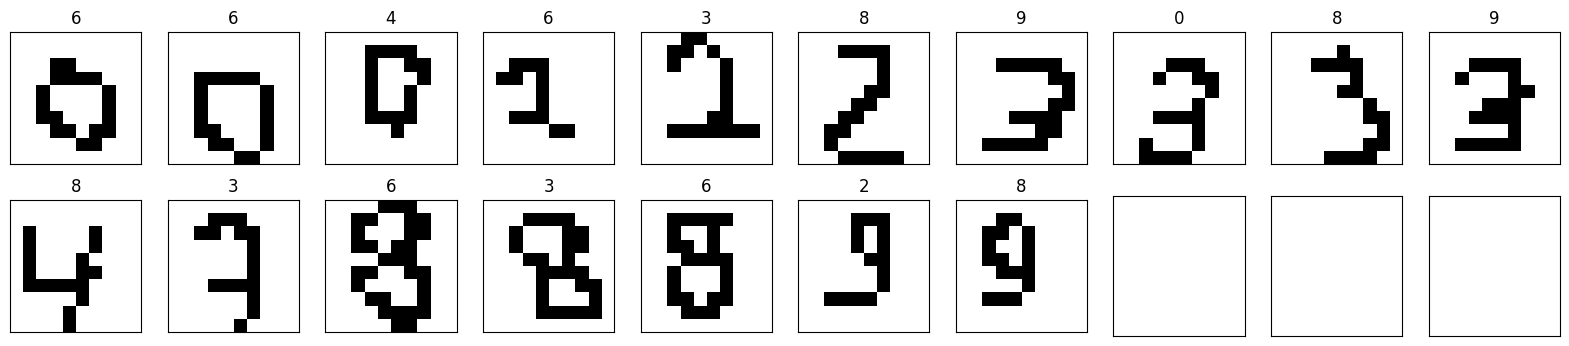

In [41]:
X_incorrects = X_test[np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)]
y_incorrects = np.argmax(pred[np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)], axis=1)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(len(X_incorrects)):
  i_a = i // 10
  j_a = i % 10
  axes[i_a, j_a].imshow(X_incorrects[i].reshape(10, 10), "binary")
  axes[i_a, j_a].set_title(y_incorrects[i])

for ax in axes.ravel():
  ax.set_yticks([])
  ax.set_xticks([])

plt.show()

In [42]:
X_corrects = X_test[np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)]
y_corrects = np.argmax(pred[np.argmax(pred, axis=1) == np.argmax(y_test, axis=1)], axis=1)
for i in range(10):
  i_acc =  len(X_corrects[y_corrects == i]) / 10
  false_answers =  np.argmax(pred[np.all(((np.argmax(pred, axis=1) != np.argmax(y_test, axis=1)), (i == np.argmax(y_test, axis=1))), axis=0)], axis=1)
  print(f"{i} {round(i_acc * 100, 2)}%")
  print(false_answers)

0 70.0%
[6 6 4]
1 100.0%
[]
2 70.0%
[6 3 8]
3 60.0%
[9 0 8 9]
4 90.0%
[8]
5 100.0%
[]
6 100.0%
[]
7 90.0%
[3]
8 70.0%
[6 3 6]
9 80.0%
[2 8]


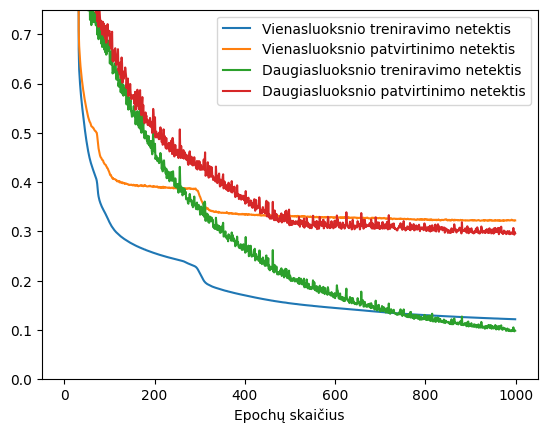

In [57]:
plot_histories_mses(model.history, model_deep.history)

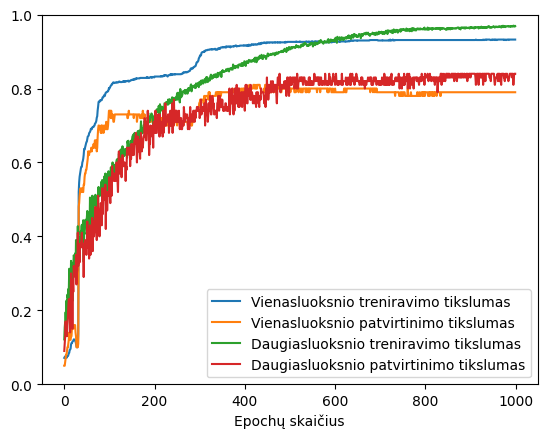

In [58]:
plot_histories_accuracies(model.history, model_deep.history)